## Константинов Даниил Николаевич
## Группа М05-015а

In [ ]:
!pip install python-constraint


In [33]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from constraint import *
import random
#from pysat.solvers import Glucose3

За парсер и данные благодарность Игорю Дьяченко!

In [34]:
class Pos:
    def __init__(self, *arr):
        assert len(arr) == 2
        self.xy = arr
        self.x = arr[0]
        self.y = arr[1]
    
    def __add__(self, that):
        return [a + b for a, b in zip(self.xy, that.xy)]
    
    def __sub__(self, that):
        return [a - b for a, b in zip(self.xy, that.xy)]
    
    def __neg__(self):
        return [-a for a in self.xy]
    
    def __str__(self):
        return str(self.xy)
    
    def __repr__(self):
        return str(self)
    
    def parse(s):
        arr = [int(a) for a in s.split(',')]
        return Pos(*arr)


class Box:
    def __init__(self, line):
        arr = line.split('\t')
        self.pos = Pos.parse(arr[0])
        
        self.size = Pos.parse(arr[1])
        self.offsets = [Pos.parse(pos) for pos in arr[2].split(' ')]

        
        assert len(self.offsets) > 0
    
    def __str__(self):
        return 'Box(pos={}, size={}, offsets={})'.format(self.pos, self.size, self.offsets)
    
    def __repr__(self):
        return str(self)


In [35]:
# проверка на пересечение
# входные данные: левый нижний угол + ширина + высота
def is_cross(a,b):
    ax1, ay1, w, h = a[0], a[1], a[2], a[3]
    ax2, ay2 = ax1 + w, ay1 + h
    bx1, by1, ww, hh = b[0], b[1], b[2], b[3]
    bx2, by2 = bx1 + ww, by1 + hh

    xA = [ax1,ax2]
    xB = [bx1,bx2] 

    yA = [ay1, ay2]  
    yB = [by1, by2]  

    if max(xA) < min(xB) or max(yA) < min(yB) or min(yA) > max(yB) or min(xA) > max(xB):    # если поменять неравенства на нестрогие, то метки будут смогут пересекаться по границам
      return False    # не пересекаются
    else:
      return True

# для создания лямбда функций
def makeFunc(row):
  return lambda a, b: (a - row[2]) or (b - row[3]) != 0


In [36]:
# данные
raw_data_0 = """
20,20	10,10	0,0 10,0 0,10 10,10
20,25	10,10	0,0 10,0 0,10 10,10
25,20	10,10	0,0 10,0 0,10 10,10
25,25	10,10	0,0 10,0 0,10 10,10
"""

raw_data_1 = '''
20,20	10,10	0,0 10,0 0,10 10,10
20,25	10,10	0,0 10,0 0,10 10,10
25,20	10,10	0,0 10,0 0,10 10,10
25,25	10,10	0,0 10,0 0,10 10,10
20,60	10,10	0,0 10,0 0,10 10,10
20,65	10,10	0,0 10,0 0,10 10,10
25,60	10,10	0,0 10,0 0,10 10,10
25,65	10,10	0,0 10,0 0,10 10,10
60,20	10,10	0,0 10,0 0,10 10,10
60,25	10,10	0,0 10,0 0,10 10,10
65,20	10,10	0,0 10,0 0,10 10,10
65,25	10,10	0,0 10,0 0,10 10,10
60,60	10,10	0,0 10,0 0,10 10,10
60,65	10,10	0,0 10,0 0,10 10,10
65,60	10,10	0,0 10,0 0,10 10,10
65,65	10,10	0,0 10,0 0,10 10,10
'''

raw_data_2 = """
25,20	10,10	0,0 10,0 0,10 10,10
25,40	10,30	0,0 10,0 0,15 10,15 0,30 10,30
25,60	10,10	0,0 10,0 0,10 10,10
40,25	20,10	0,0 10,0 20,0 0,10 10,10 20,10
40,40	20,20	0,0 10,0 20,0 0,10 10,10 20,10 0,20 10,20 20,20
40,55	20,10	0,0 10,0 20,0 0,10 10,10 20,10
55,35	10,20	0,0 10,0 0,10 10,10 0,20 10,20
55,40	10,20	0,0 10,0 0,10 10,10 0,20 10,20
"""

raw_data_3 = """
111,152	33,47	0,0 33,0 0,47 33,47
55,142	35,25	0,0 35,0 0,25 35,25
73,62	40,21	0,0 40,0 0,21 40,21 0,7 40,7 0,14 40,14
54,193	10,48	0,0 10,0 0,48 10,48
191,7	18,47	0,0 6,0 12,0 18,47 18,0 0,47 6,47 12,47
187,135	29,23	0,0 29,0 0,23 29,23
174,50	45,22	0,0 45,0 0,22 45,22 15,0 30,0 15,22 30,22
33,31	34,29	0,0 34,0 0,29 34,29
193,174	14,14	0,0 14,0 0,14 14,14
155,140	25,20	0,0 25,0 0,20 25,20
136,92	20,31	0,0 20,0 0,31 20,31
71,187	25,29	0,0 25,0 0,29 25,29
104,38	53,11	0,0 53,0 0,11 53,11
83,41	14,24	0,0 14,0 0,24 14,24
29,158	16,41	0,0 16,0 0,41 16,41
7,107	31,21	0,0 31,0 0,21 31,21
128,5	15,10	0,0 15,0 0,10 15,10
53,111	12,20	0,0 12,0 0,20 12,20
22,5	24,10	0,0 24,0 0,10 24,10 12,0 12,10
167,5	11,42	0,0 11,0 0,42 11,42
114,125	10,23	0,0 10,0 0,23 10,23
143,145	11,45	0,0 11,0 0,45 11,45
57,100	37,18	0,0 37,0 0,18 37,18
176,99	12,32	0,0 12,0 0,32 12,32
28,130	18,12	0,0 18,0 0,12 18,12
"""
raw_data_4 = """
75,63	52,38	0,0 13,0 26,0 39,0 52,0 0,38 13,38 26,38 39,38 52,38
123,106	52,27	0,0 52,0 0,27 52,27
192,66	42,25	0,0 42,0 0,25 42,25
46,30	47,24	0,0 47,0 0,8 47,8 0,16 47,16 0,24 47,24
96,34	14,17	0,0 14,0 0,17 14,17
15,177	30,33	0,0 15,0 30,0 0,33 15,33 30,33
61,68	56,27	0,0 56,0 0,27 56,27
115,33	50,19	0,0 50,0 0,19 50,19
62,176	37,22	0,0 37,0 0,22 37,22
103,189	33,46	0,0 33,0 0,46 33,46
31,98	25,41	0,0 25,0 0,41 25,41
179,25	17,17	0,0 17,0 0,17 17,17
167,180	27,26	0,0 27,0 0,26 27,26
130,28	35,20	0,0 35,0 0,20 35,20
104,120	47,11	0,0 47,0 0,11 47,11
188,165	10,17	0,0 10,0 0,17 10,17
27,47	15,42	0,0 15,0 0,42 15,42
186,186	27,11	0,0 9,0 18,0 27,0 0,11 9,11 18,11 27,11
53,141	12,10	0,0 12,0 0,2 12,2 0,4 12,4 0,6 12,6 0,8 12,8 0,10 12,10
126,26	15,15	0,0 15,0 0,15 15,15
"""
raw_data_5 = """
97,148	59,25	0,0 59,0 0,25 59,25
49,75	36,46	0,0 36,0 0,46 36,46
61,15	24,20	0,0 24,0 0,10 24,10 0,20 24,20
141,166	10,31	0,0 5,0 10,0 0,31 5,31 10,31
137,34	42,42	0,0 42,0 0,21 42,21 0,42 42,42
121,92	36,21	0,0 36,0 0,21 36,21
172,117	21,19	0,0 21,0 0,19 21,19
137,122	54,30	0,0 54,0 0,15 54,15 0,30 54,30
99,161	19,22	0,0 19,0 0,22 19,22
87,20	24,25	0,0 8,0 16,0 24,0 0,25 8,25 16,25 24,25
134,161	49,18	0,0 49,0 0,18 49,18
84,187	38,13	0,0 19,0 38,0 0,13 19,13 38,13
76,141	57,18	0,0 57,0 0,18 57,18
111,15	15,45	0,0 5,0 10,0 15,0 0,45 5,45 10,45 15,45
189,162	30,19	0,0 10,0 20,0 30,0 0,19 10,19 20,19 30,19
181,6	28,26	0,0 14,0 28,0 0,26 14,26 28,26
20,147	24,17	0,0 8,0 16,0 24,0 0,17 8,17 16,17 24,17
57,53	31,15	0,0 31,0 0,15 31,15
203,138	15,20	0,0 15,0 0,20 15,20
39,179	14,25	0,0 14,0 0,25 14,25
185,65	16,42	0,0 16,0 0,42 16,42
71,97	12,47	0,0 12,0 0,47 12,47
"""

In [37]:
name_data = raw_data_5

boxes = [Box(line) for line in name_data.strip().split('\n')]

In [38]:
# положения каждой рамки кодируются числами от 0 до 8 (всего 9 положений)
constr = []

for i in range(len(boxes) - 1):
  v1 = boxes[i]
  for j in range(i + 1, len(boxes)):
      v2 = boxes[j]
      for i1 in range(len(v1.offsets)):  # проверям на пересечения
        v1_off = v1.offsets[i1]
        v1_rect = [v1.pos.x - v1_off.x, v1.pos.y - v1.size.y + v1_off.y, v1.size.x, v1.size.y]
        for i2 in range(len(v2.offsets)):
          v2_off = v2.offsets[i2]
          v2_rect = [v2.pos.x - v2_off.x, v2.pos.y - v2.size.y + v2_off.y, v2.size.x, v2.size.y]
          if is_cross(v1_rect, v2_rect):
            constr.append([i + 1, j + 1, i1, i2])


In [39]:
# солвер для решения
problem = Problem()
for i in range(1, len(boxes) + 1):
  lenn = len(boxes[i-1].offsets)
  problem.addVariable(i, [j for j in range(0, lenn)])

for row in constr:
  problem.addConstraint(makeFunc(row), (row[0], row[1]))

In [40]:
sol = problem.getSolution()

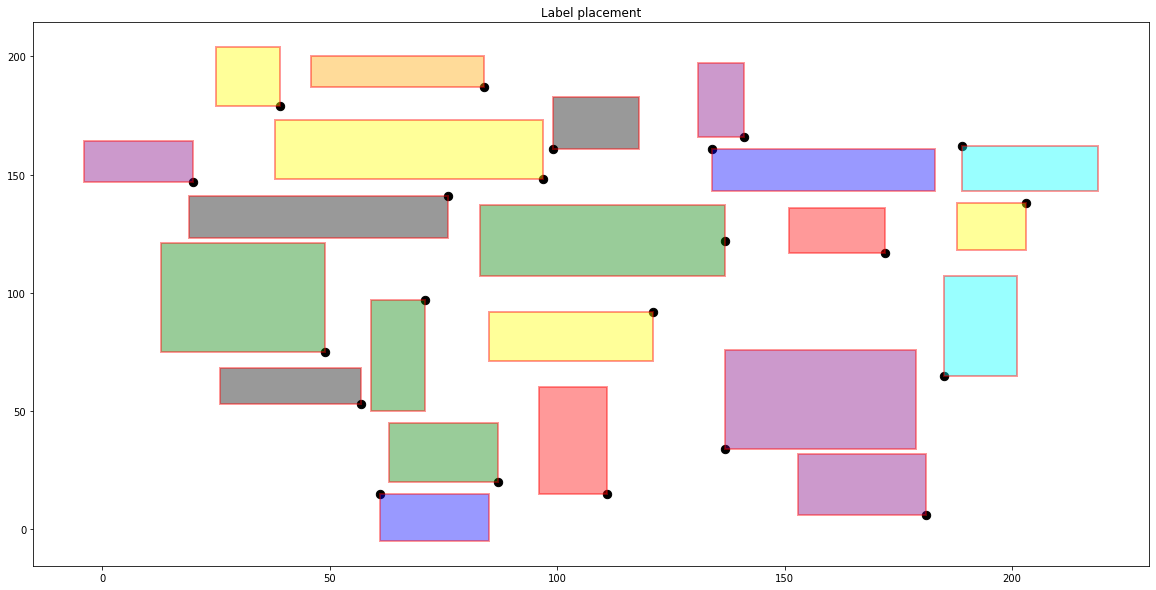

In [50]:
if len(sol) == 0:
  print("Нет решений")
else:
  x = []
  y = []
  for boxx in boxes:
      x.append(boxx.pos.x)
      y.append(boxx.pos.y)

  fig, ax = plt.subplots(figsize=(20,10))

  ax.scatter(x, y, s=70, color="black")
  array_colors = ['red','blue', 'green', 'black', 'yellow', 'purple','orange','cyan']

  positions = sol

  for i, boxx in enumerate(boxes):
    left_corner = (boxx.pos.x - boxx.offsets[positions[i+1]].x, boxx.pos.y - boxx.size.y + boxx.offsets[positions[i+1]].y)
    width = boxx.size.x
    height = boxx.size.y
    colorr = random.choice(array_colors)
    lab = patches.Rectangle(left_corner, width, height, edgecolor='red', linewidth=2, facecolor=colorr, fill=True, alpha=0.4) 
    # Координата левого нижнего угла - (1, 1), ширина - 1 и высота - 2.
    ax.add_patch(lab)

  plt.title('Label placement')
  plt.show()

In [ ]:
## неудачные попытки

In [ ]:
!pip install python-sat[pblib,aiger]  # солвер для SAT

# возвращает нужные числа в зависимости от места label
# i = 0..8
# n - номер вершины (1, 2, ...)
def coding(n, i):
  w = range(n * 4 -3, (n + 1) * 4 -3)
  if i == 0:
    return [-w[0], -w[1], -w[2], -w[3]]
  if i == 1:
    return [-w[0], -w[1], -w[2], w[3]]
  if i == 2:
    return [-w[0], -w[1], w[2], -w[3]]
  if i == 3:
    return [-w[0], -w[1], w[2], w[3]]
  if i == 4:
    return [-w[0], w[1], -w[2], -w[3]]
  if i == 5:
    return [-w[0], w[1], -w[2], w[3]]
  if i == 6:
    return [-w[0], w[1], w[2], -w[3]]
  if i == 7:
    return [-w[0], w[1], w[2], w[3]]
  if i == 8:
    return [w[0], -w[1], -w[2], -w[3]]

g = Glucose3()

for i in range(len(boxes) - 1):
  v1 = boxes[i]
  print(v1)
  for j in range(i + 1, len(boxes)):
      v2 = boxes[j]
      print(v2)
      for i1 in range(len(v1.offsets)):  # проверям на пересечения
        v1_off = v1.offsets[i1]
        v1_rect = [v1.pos.x - v1_off.x, v1.pos.y - v1.size.y + v1_off.y, v1.size.x, v1.size.y]
        for i2 in range(len(v2.offsets)):
          v2_off = v2.offsets[i2]
          v2_rect = [v2.pos.x - v2_off.x, v2.pos.y - v2.size.y + v2_off.y, v2.size.x, v2.size.y]
          if is_cross(v1_rect, v2_rect):
            v1_cod = coding4(i + 1, i1)
            v2_cod = coding4(j + 1, i2)
            print(v1_cod + v2_cod)
            g.add_clause(v1_cod + v2_cod)
print(g.solve())
print(g.get_model())

[{1: 1, 2: 1}, {1: 0, 2: 0}, {1: 0, 2: 1}]